In [1]:
from os.path import join
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import t
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
# sns.set(font_scale = 1.5)
sns.set_context("talk")

import datetime
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/Shareddrives/TuriLab/Data/PTSD_project/!analysis/saveFolder/'

Mounted at /content/drive


In [3]:
worksheet = gc.open('all_cohorts_freezing_FINAL').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(data)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df.reset_index(inplace=True, drop=True)

# swapping out 'ptsd' to sefl in condition column
df.loc[:,('condition')].replace('ptsd','SEFL', inplace=True)
# replacing NA to NaN
df.replace('NA', np.NaN, inplace=True)
# changing `freezing` dtype to float
df['freezing'] = pd.to_numeric(df['freezing'],
                                        downcast='float')
# adding unique ID-s based on `id` and `cohort`
df['cohort_id']= df['cohort']+'_'+df['id']

df['date_time'] = df['date']+' '+df['time']
df['man_date_time'] = pd.to_datetime(df['date_time'])

df['date'] = df['date'].astype('datetime64[ns]', copy=False)

print(df.dtypes)
df.head()

0
freezing                    float32
genotype                     object
id                           object
day                          object
condition                    object
sex                          object
cohort                       object
exposure_mins                object
analyzed_duration            object
date                 datetime64[ns]
time                         object
els                          object
cohort_id                    object
date_time                    object
man_date_time        datetime64[ns]
dtype: object


,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,cohort_id,date_time,man_date_time
0,3.510000,2aFlox_het,5HT2Afl05a-5,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,n,ptsd1_5HT2Afl05a-5,4/3/2021 1:34 PM,2021-04-03 13:34:00
1,3.080000,wt,5HT2Afl05a-7,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,n,ptsd1_5HT2Afl05a-7,4/3/2021 1:34 PM,2021-04-03 13:34:00
2,0.800000,wt,5HT2ACre01a-3,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,n,ptsd1_5HT2ACre01a-3,4/3/2021 1:34 PM,2021-04-03 13:34:00
3,0.700000,wt,sert26a-3,sefla,control,male,ptsd1,60,60,2021-04-03,1:58 PM,n,ptsd1_sert26a-3,4/3/2021 1:58 PM,2021-04-03 13:58:00
4,45.130001,wt,5HT2Afl5a-6,sefla,SEFL,male,ptsd1,60,60,2021-04-03,3:03 PM,n,ptsd1_5HT2Afl5a-6,4/3/2021 3:03 PM,2021-04-03 15:03:00


In [7]:
worksheet = gc.open('id_dob').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)

# Convert to a DataFrame and render.
import pandas as pd
dob_df = pd.DataFrame.from_records(data)
dob_df.columns = dob_df.iloc[0]
dob_df.drop(dob_df.index[0], inplace=True)
dob_df.reset_index(inplace=True, drop=True)

dob_df['cohort_id']= dob_df['cohort']+'_'+dob_df['id']
dob_df.drop(['id', 'cohort'], axis=1, inplace=True )
dob_df['dob'] = dob_df['dob'].astype('datetime64[ns]')

dob_df.head()
print(f'dob_df shape{dob_df.shape}')

dob_df shape(147, 2)


In [8]:
# merging freezing w/ DOBs
merged_df = df.merge(dob_df,left_on='cohort_id', right_on='cohort_id')
print(merged_df.dtypes)
print(f'merged_df shape {merged_df.shape}')
merged_df.head()

0
freezing                    float32
genotype                     object
id                           object
day                          object
condition                    object
sex                          object
cohort                       object
exposure_mins                object
analyzed_duration            object
date                 datetime64[ns]
time                         object
els                          object
cohort_id                    object
date_time                    object
man_date_time        datetime64[ns]
dob                  datetime64[ns]
dtype: object
merged_df shape (1165, 16)


,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,cohort_id,date_time,man_date_time,dob
0,3.510000,2aFlox_het,5HT2Afl05a-5,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,n,ptsd1_5HT2Afl05a-5,4/3/2021 1:34 PM,2021-04-03 13:34:00,2020-12-11
1,8.940000,2aFlox_het,5HT2Afl05a-5,seflb,control,male,ptsd1,3.5,3.5,2021-04-04,9:52 AM,n,ptsd1_5HT2Afl05a-5,4/4/2021 9:52 AM,2021-04-04 09:52:00,2020-12-11
2,43.099998,2aFlox_het,5HT2Afl05a-5,recall1,control,male,ptsd1,0,5,2021-04-05,9:35 AM,n,ptsd1_5HT2Afl05a-5,4/5/2021 9:35 AM,2021-04-05 09:35:00,2020-12-11
3,22.610001,2aFlox_het,5HT2Afl05a-5,recall2,control,male,ptsd1,5,5,2021-04-07,10:36 AM,n,ptsd1_5HT2Afl05a-5,4/7/2021 10:36 AM,2021-04-07 10:36:00,2020-12-11
4,37.220001,2aFlox_het,5HT2Afl05a-5,recall3,control,male,ptsd1,5,5,2021-04-09,10:17 AM,n,ptsd1_5HT2Afl05a-5,4/9/2021 10:17 AM,2021-04-09 10:17:00,2020-12-11


In [5]:
worksheet = gc.open('Learing_slopes_pre_sock06').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)
# Convert to a DataFrame and render.
import pandas as pd
learning_df = pd.DataFrame.from_records(data)
learning_df.columns = learning_df.iloc[0]
learning_df.drop(learning_df.index[0], inplace=True)
learning_df.reset_index(inplace=True, drop=True)
learning_df.drop([''], axis=1, inplace=True)
learning_df['slope'] = pd.to_numeric(learning_df['slope'],
                                        downcast='float')

# learning_df.head(2)
learning_df.dtypes
# learning_df.shape

0
cohort_id     object
group         object
sex           object
els           object
dob           object
genotype      object
slope        float32
dtype: object

In [9]:
keys = list(learning_df['cohort_id'].values)
df = merged_df[merged_df['cohort_id'].isin(keys)]
df.shape

(768, 16)

In [10]:
df_slope = df.merge(learning_df,left_on='cohort_id', right_on='cohort_id')
# # print(merged_df.dtypes)
df_slope.shape
df_slope.dtypes

0
freezing                    float32
genotype_x                   object
id                           object
day                          object
condition                    object
sex_x                        object
cohort                       object
exposure_mins                object
analyzed_duration            object
date                 datetime64[ns]
time                         object
els_x                        object
cohort_id                    object
date_time                    object
man_date_time        datetime64[ns]
dob_x                datetime64[ns]
group                        object
sex_y                        object
els_y                        object
dob_y                        object
genotype_y                   object
slope                       float32
dtype: object

In [12]:
df_slope.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   freezing           768 non-null    float32       
 1   genotype_x         768 non-null    object        
 2   id                 768 non-null    object        
 3   day                768 non-null    object        
 4   condition          768 non-null    object        
 5   sex_x              768 non-null    object        
 6   cohort             768 non-null    object        
 7   exposure_mins      768 non-null    object        
 8   analyzed_duration  768 non-null    object        
 9   date               768 non-null    datetime64[ns]
 10  time               768 non-null    object        
 11  els_x              768 non-null    object        
 12  cohort_id          768 non-null    object        
 13  date_time          768 non-null    object        
 14  man_date_t

In [13]:
df_slope

,freezing,genotype_x,id,day,condition,sex_x,cohort,exposure_mins,analyzed_duration,date,...,cohort_id,date_time,man_date_time,dob_x,group,sex_y,els_y,dob_y,genotype_y,slope
0,5.03,wt,81,sefla,control,male,ptsd2,60,60,2021-04-28,...,ptsd2_81,4/28/2021 11:59 AM,2021-04-28 11:59:00,2021-02-16,Control,Male,n,2021-02-16,wt,0.0541
1,0.45,wt,81,seflb,control,male,ptsd2,3.5,3.5,2021-04-29,...,ptsd2_81,4/29/2021 4:40 PM,2021-04-29 16:40:00,2021-02-16,Control,Male,n,2021-02-16,wt,0.0541
2,8.28,wt,81,recall1,control,male,ptsd2,5,5,2021-04-30,...,ptsd2_81,4/30/2021 1:37 PM,2021-04-30 13:37:00,2021-02-16,Control,Male,n,2021-02-16,wt,0.0541
3,7.12,wt,81,recall2,control,male,ptsd2,5,5,2021-05-03,...,ptsd2_81,5/3/2021 10:17 AM,2021-05-03 10:17:00,2021-02-16,Control,Male,n,2021-02-16,wt,0.0541
4,7.57,wt,81,recall3,control,male,ptsd2,5,5,2021-05-05,...,ptsd2_81,5/5/2021 10:04 AM,2021-05-05 10:04:00,2021-02-16,Control,Male,n,2021-02-16,wt,0.0541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,21.82,wt,921-4,recall2,control,female,els1,,,2022-02-25,...,els1_921-4,2/25/22,2022-02-25 00:00:00,2021-10-25,Control,Female,n,2021-10-25,wt,0.0439
764,18.85,wt,921-4,recall3,control,female,els1,,,2022-03-04,...,els1_921-4,3/4/22,2022-03-04 00:00:00,2021-10-25,Control,Female,n,2021-10-25,wt,0.0439
765,8.49,wt,921-4,recall4,control,female,els1,,,2022-03-10,...,els1_921-4,3/10/22,2022-03-10 00:00:00,2021-10-25,Control,Female,n,2021-10-25,wt,0.0439
766,19.09,wt,921-4,recall5,control,female,els1,,,2022-03-18,...,els1_921-4,3/18/22,2022-03-18 00:00:00,2021-10-25,Control,Female,n,2021-10-25,wt,0.0439


In [14]:
df_scatter = df_slope[(df_slope['day']=='recall5') &
                      (df_slope['condition']== 'SEFL')]
df_scatter.head(2)

,freezing,genotype_x,id,day,condition,sex_x,cohort,exposure_mins,analyzed_duration,date,...,cohort_id,date_time,man_date_time,dob_x,group,sex_y,els_y,dob_y,genotype_y,slope
38,17.639999,wt,84,recall5,SEFL,male,ptsd2,5,5,2021-06-02,...,ptsd2_84,6/2/2021 10:29 AM,2021-06-02 10:29:00,2021-02-16,SEFL,Male,n,2021-02-16,wt,0.5663
46,8.820000,wt,93,recall5,SEFL,male,ptsd2,5,5,2021-06-02,...,ptsd2_93,6/2/2021 10:03 AM,2021-06-02 10:03:00,2021-02-16,SEFL,Male,n,2021-02-16,wt,0.6712


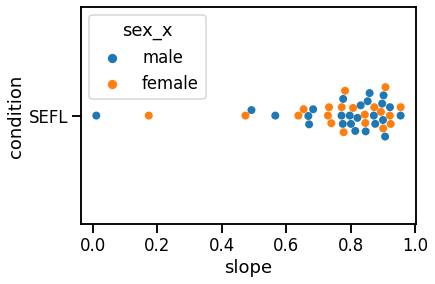

In [17]:
g = sns.swarmplot(x='slope', y='condition',
                  data=df_scatter,size=8, hue='sex_x')

In [33]:
# these are the llow slope guys: 
df_scatter[df_scatter['slope']<0.4]

,freezing,genotype_x,id,day,condition,sex_x,cohort,exposure_mins,analyzed_duration,date,...,cohort_id,date_time,man_date_time,dob_x,group,sex_y,els_y,dob_y,genotype_y,slope
110,24.120001,wt,12,recall5,SEFL,male,ptsd3,5,5,2021-06-24,...,ptsd3_12,6/24/2021 2:21 PM,2021-06-24 14:21:00,2021-01-03,Control,Male,n,2021-01-03,wt,0.0111
526,22.340000,sert_het,917-3,recall5,SEFL,female,ptsd8,5,5,2022-01-13,...,ptsd8_917-3,1/13/2022 3:09 PM,2022-01-13 15:09:00,2021-09-04,SEFL,Female,n,2021-09-04,sert,0.1738


In [35]:
df_scatter.head(2)

,freezing,genotype_x,id,day,condition,sex_x,cohort,exposure_mins,analyzed_duration,date,...,cohort_id,date_time,man_date_time,dob_x,group,sex_y,els_y,dob_y,genotype_y,slope
38,17.639999,wt,84,recall5,SEFL,male,ptsd2,5,5,2021-06-02,...,ptsd2_84,6/2/2021 10:29 AM,2021-06-02 10:29:00,2021-02-16,SEFL,Male,n,2021-02-16,wt,0.5663
46,8.820000,wt,93,recall5,SEFL,male,ptsd2,5,5,2021-06-02,...,ptsd2_93,6/2/2021 10:03 AM,2021-06-02 10:03:00,2021-02-16,SEFL,Male,n,2021-02-16,wt,0.6712


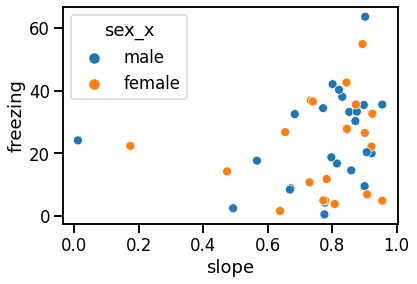

In [19]:
sns.scatterplot(data=df_scatter, y='freezing', x='slope', 
                hue='sex_x')

i'm not sure what's going on with that one mouse in the left. exclude it for now

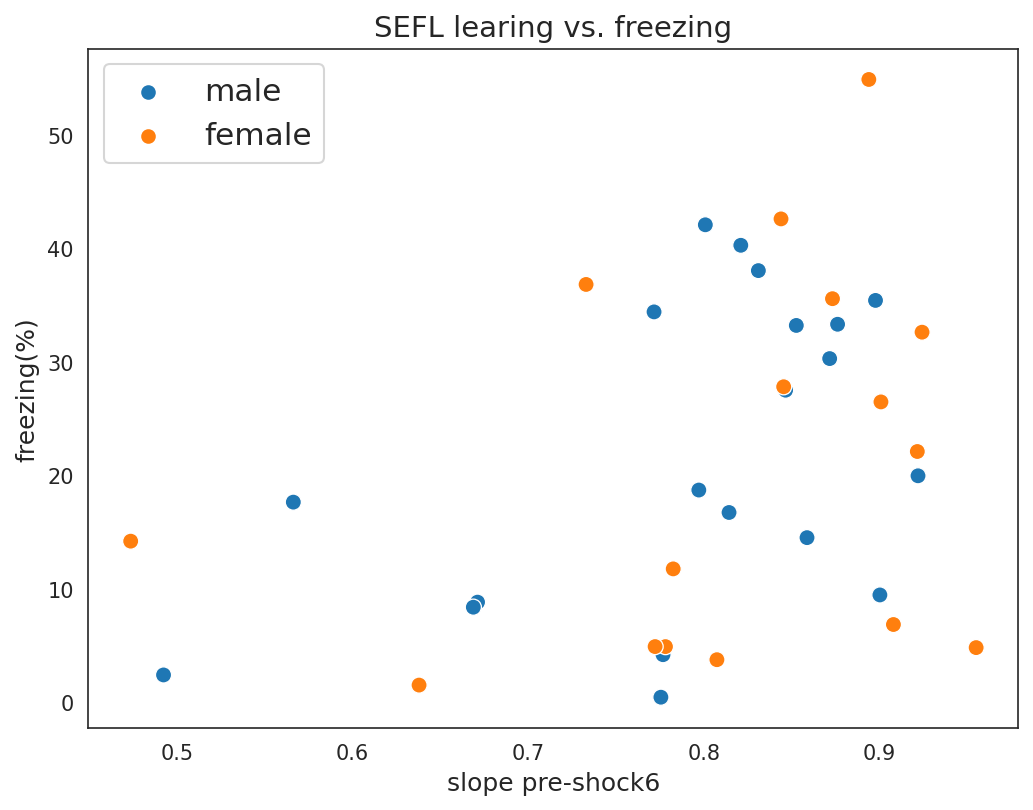

In [ ]:
g = sns.scatterplot(data=df_scatter[df_scatter['slope_pre_shock06']>0.1], y='freezing', x='slope_pre_shock06', 
                hue='sex', ax=ax, s=60)
plt.legend(fontsize=15)
plt.xlabel("slope pre-shock6", size=12)
plt.ylabel("freezing(%)", size=12)
plt.title('SEFL learing vs. freezing', size=14)
# fig.savefig(os.path.join(save_path, 'SEFL_learning_frezing_scatter.png'),
#             transparent=True)

Text(0.5, 1.0, 'SEFL learing vs. freezing')

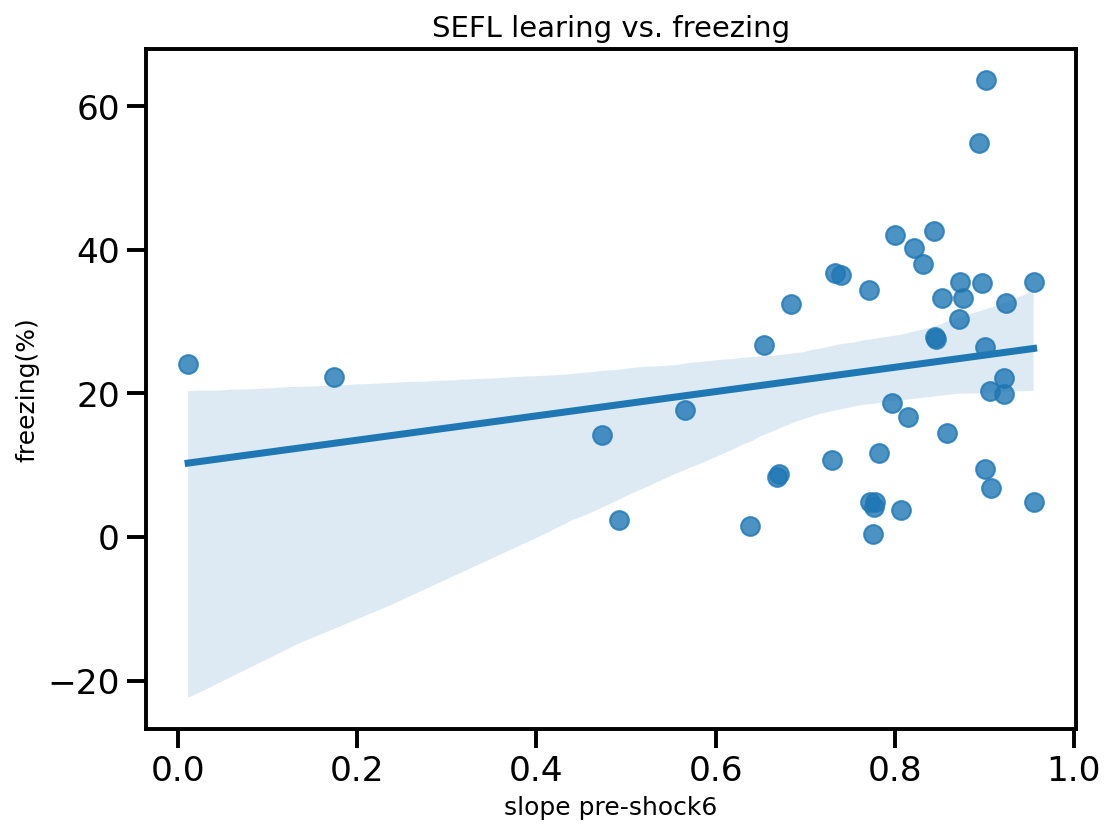

In [20]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

g = sns.regplot(data=df_scatter,
            x='slope', y='freezing',)
plt.xlabel("slope pre-shock6", size=12)
plt.ylabel("freezing(%)", size=12)
plt.title('SEFL learing vs. freezing', size=14)
# fig.savefig(os.path.join(save_path, 'SEFL_learning_frezing_regression.png'),
#             transparent=True)

Text(0.5, 1.0, 'SEFL learing vs. freezing')

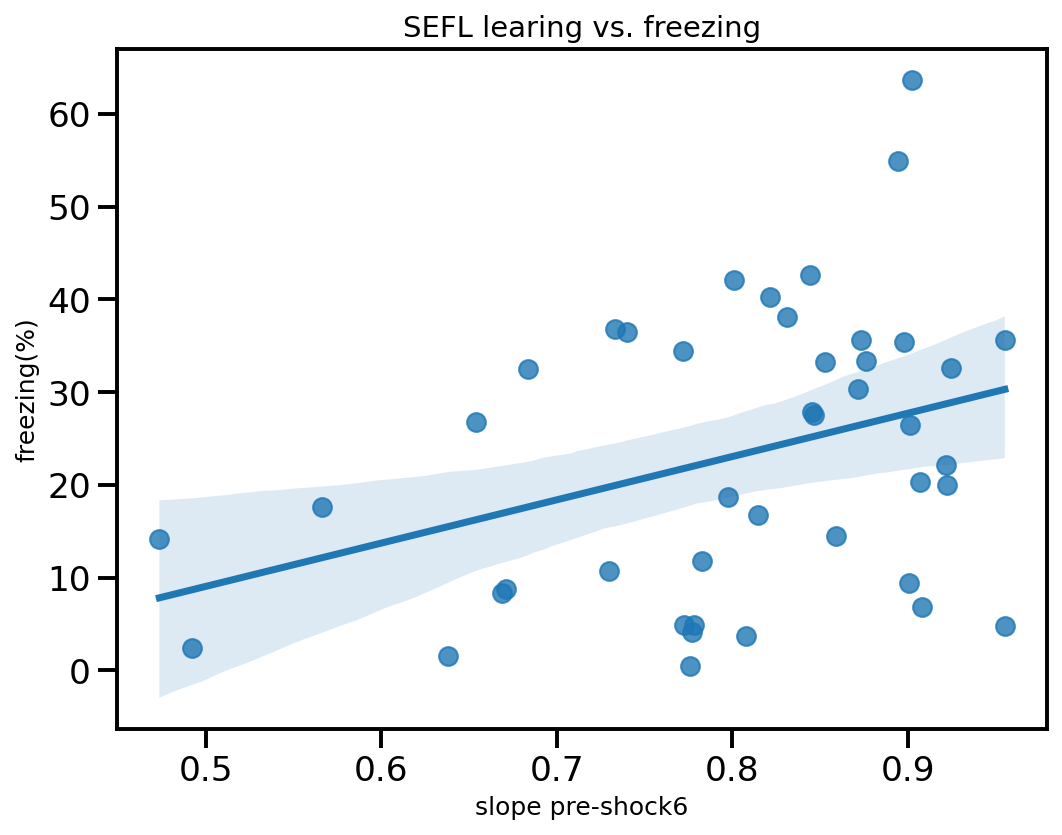

In [21]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

g = sns.regplot(data=df_scatter[df_scatter['slope']>0.2],
            x='slope', y='freezing', ax=ax 
            )
plt.xlabel("slope pre-shock6", size=12)
plt.ylabel("freezing(%)", size=12)
plt.title('SEFL learing vs. freezing', size=14)
# fig.savefig(os.path.join(save_path, 'SEFL_learning_frezing_regression.png'),
#             transparent=True)

In [32]:
regress_df = df_scatter[df_scatter['slope']>0.2]
x= regress_df['slope']
y= regress_df['freezing']
# slope, intercept, r, p, se = linregress(regress_df['slope'],regress_df['freezing'])
res = linregress(x,y)
print(f"R: {res.rvalue:.6f}")
print(f"R-squared: {res.rvalue**2:.6f}")
print(f"p: {res.pvalue:.6f}")

R: 0.351467
R-squared: 0.123529
p: 0.020828


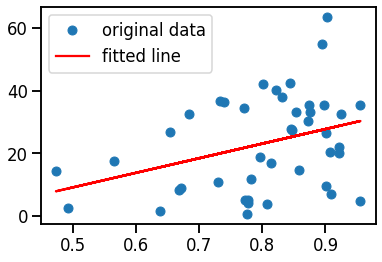

In [24]:
plt.plot(x, y,'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

In [25]:
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(x)-2)

print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}") 
print(f"intercept (95%): {res.intercept:.6f}")
# print(f" +/- {ts*res.intercept_stderr:.6f}")

slope (95%): 46.682203 +/- 39.218971
intercept (95%): -14.280150


### checking the validity of the regression model based on [this](https://www.statology.org/residual-plot-python/)and [this](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)

In [27]:
model = ols('freezing ~ slope',data=regress_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               freezing   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     5.779
Date:                Sun, 01 May 2022   Prob (F-statistic):             0.0208
Time:                        23:26:31   Log-Likelihood:                -175.18
No. Observations:                  43   AIC:                             354.4
Df Residuals:                      41   BIC:                             357.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.2801     15.710     -0.909      0.3

In [28]:
model.params

Intercept   -14.280148
slope        46.682203
dtype: float64

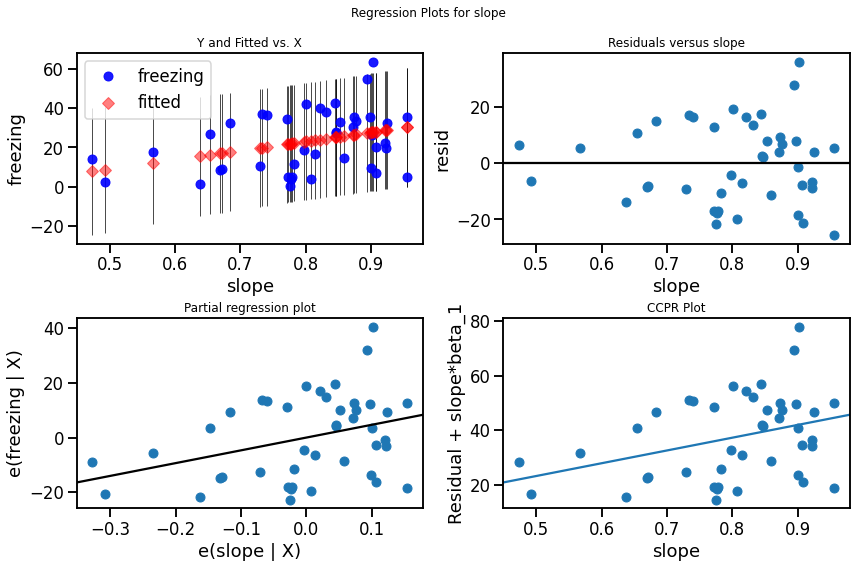

In [30]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'slope', fig=fig)

In [ ]:
merged_df.head()

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,cohort_id,date_time,man_date_time,dob
0,3.510000,2aFlox_het,5HT2Afl05a-5,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,ptsd1_5HT2Afl05a-5,4/3/2021 1:34 PM,2021-04-03 13:34:00,2020-12-11
1,8.940000,2aFlox_het,5HT2Afl05a-5,seflb,control,male,ptsd1,3.5,3.5,NaT,NaN,ptsd1_5HT2Afl05a-5,NaN,NaT,2020-12-11
2,43.099998,2aFlox_het,5HT2Afl05a-5,recall1,control,male,ptsd1,0,5,NaT,NaN,ptsd1_5HT2Afl05a-5,NaN,NaT,2020-12-11
3,22.610001,2aFlox_het,5HT2Afl05a-5,recall2,control,male,ptsd1,5,5,NaT,NaN,ptsd1_5HT2Afl05a-5,NaN,NaT,2020-12-11
4,37.220001,2aFlox_het,5HT2Afl05a-5,recall3,control,male,ptsd1,5,5,NaT,NaN,ptsd1_5HT2Afl05a-5,NaN,NaT,2020-12-11


In [ ]:
new_df = merged_df.loc[:, ('freezing','condition', 'sex', 'cohort_id', 'day')]
new_df
# unm = new_df.set_index(['cohort_id', 'condition', 'sex'])['day']
# unm
unm = new_df.pivot(index=['cohort_id','condition', 'sex'],
                   columns=['day'])['freezing']
unm
unm_sefl = unm.filter(like='SEFL', axis=0)
# unm_sefl.reset_index(drop=True)
unm_sefl
# unm_sefl.dtypes

Text(0.5, 1.0, 'SEFL recall1 vs. recall5')

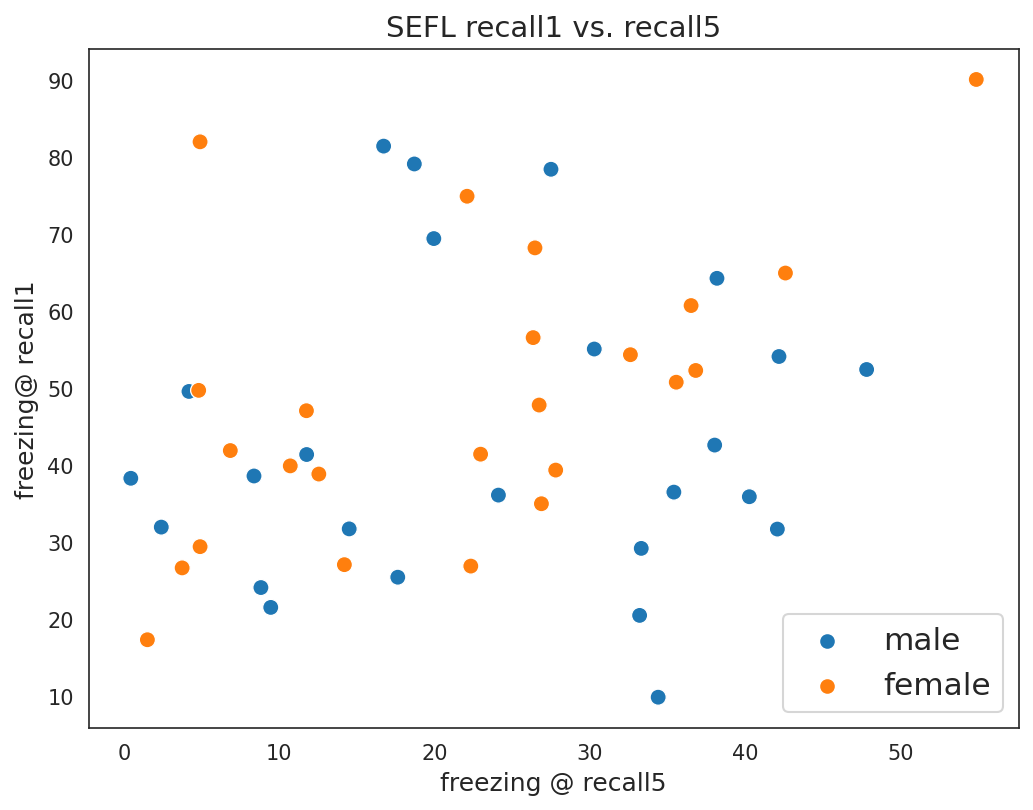

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
g = sns.scatterplot(data=unm_sefl, y='recall1', x='recall5', 
                hue='sex', ax=ax, s=60)
plt.legend(fontsize=15)
plt.xlabel("freezing @ recall5", size=12)
plt.ylabel("freezing@ recall1", size=12)
plt.title('SEFL recall1 vs. recall5', size=14)
# fig.savefig(os.path.join(save_path, 'SEFL_learning_frezing_scatter.png'),
#             transparent=True)

Text(0.5, 1.0, 'SEFL recall1 vs. recall5')

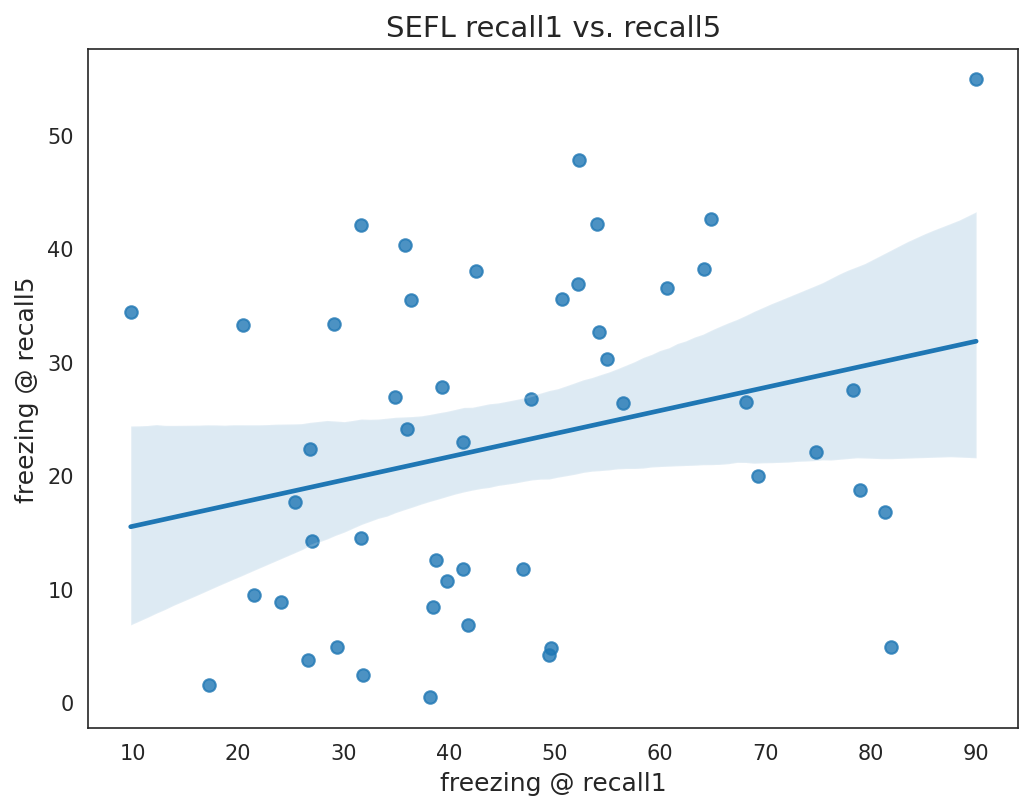

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

g = sns.regplot(data=unm_sefl,
            x='recall1', y='recall5', ax=ax 
            )
plt.xlabel("freezing @ recall1", size=12)
plt.ylabel("freezing @ recall5", size=12)
plt.title('SEFL recall1 vs. recall5', size=14)
# fig.savefig(os.path.join(save_path, 'SEFL_recall1_vs_recall5_regression.png'),
#             transparent=True)

In [ ]:
x= unm_sefl['recall1']
y= unm_sefl['recall5']
mask = ~np.isnan(unm_sefl['recall1']) & ~np.isnan(unm_sefl['recall5'])
# slope, intercept, r, p, se = linregress(regress_df['slope_pre_shock06'],regress_df['freezing'])
res = linregress(x[mask],y[mask])
print(res)
print(f"R: {res.rvalue:.6f}")
print(f"R-squared: {res.rvalue**2:.6f}")
print(f"p: {res.pvalue:.6f}")

LinregressResult(slope=0.20388648910612253, intercept=13.472121355515382, rvalue=0.2739894887816402, pvalue=0.05677389022830012, stderr=0.10439026332128959)
R: 0.273989
R-squared: 0.075070
p: 0.056774


In [ ]:
model = ols('recall1 ~ recall5',data=unm_sefl).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                recall1   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.815
Date:                Sun, 23 Jan 2022   Prob (F-statistic):             0.0568
Time:                        01:12:24   Log-Likelihood:                -211.14
No. Observations:                  49   AIC:                             426.3
Df Residuals:                      47   BIC:                             430.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.3116      5.035      7.411      0.0

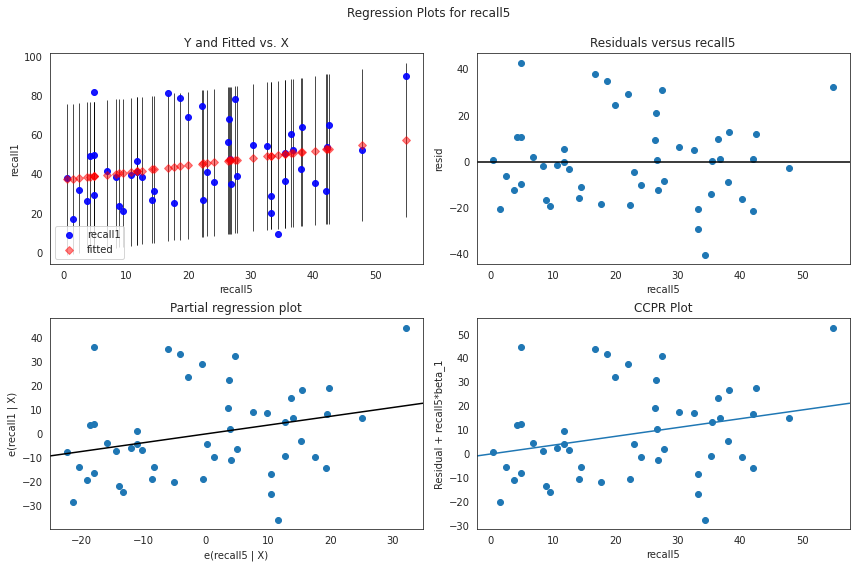

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'recall5', fig=fig)